In [ ]:
import os

import plinder.core.utils.config

cfg = plinder.core.get_config()

# print(f"local cache directory: {cfg.data.plinder_dir}")
print(f"remote data directory: {cfg.data.plinder_remote}")  # noqa: T201

remote data directory: gs://plinder/2024-06/v2


In [73]:
from plinder.core.scores import query_index

# Get system_id, entry_pdb_id, and split columns of train and val splits
df = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "system_num_ligand_chains",
        "system_num_protein_chains",
        "ligand_instance_chain",
        # "ligand_sdf",
        # "recptor_pdb"
    ],
    splits=["val"],
    # splits = ["test"]
)

2025-07-31 11:07:55,412 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.67s
2025-07-31 11:07:57,525 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.59s


In [74]:
df.__len__()

1157

In [75]:
(df.system_id + "@" + df.ligand_instance_chain).nunique()

1157

In [76]:
# Save the DataFrame to a CSV file
# splits: val
# df.to_csv("plinder_val_systems.csv", index=False)

# splits: test
# df.to_csv("plinder_test_systems.csv", index=False)

* (run this in a script, not in a notebook)
* (check `plinder_dataset_protonate.py`)

```python
import pandas as pd

from tqdm import tqdm
from protonate import plinder_system_protonate

df = pd.read_csv(
    "plinder_val_systems.csv" # modify the file path here
    )

# each_system_id = df.iloc[0]['system_id']  # Example to access system_id
for each_system_id in tqdm(df['system_id'].unique()):

    # Protonate system for each system_id
    plinder_system_protonate(plinder_system_id=each_system_id)
    
```

# HBond validation

In [77]:
import prolif as plf
from prolif.io.protein_helper import ProteinHelper
from rdkit import Chem

In [78]:
protein_helper = ProteinHelper([{"MSE": {"SMILES": "C[Se]CC[CH](N)C=O"}}])

In [79]:
# test_case_dir = f"{cfg.data.plinder_dir}/protonated_systems/5da9__1__1.A_1.B__1.E_1.F"
# test_case_dir = f"{cfg.data.plinder_dir}/protonated_systems/8dak__1__1.A_1.B__1.D"
# test_case_dir = f"{cfg.data.plinder_dir}/protonated_systems/5kod__4__1.D__1.M_1.N"
test_case_dir = "../test_data/5da9__1__1.A_1.B__1.E_1.F"

## Explicit

In [92]:
protein_mol = protein_helper.standardize_protein(
    f"{test_case_dir}/receptor_protonated2.pdb"
)

In [93]:
protein_mol.residues.__len__()

834

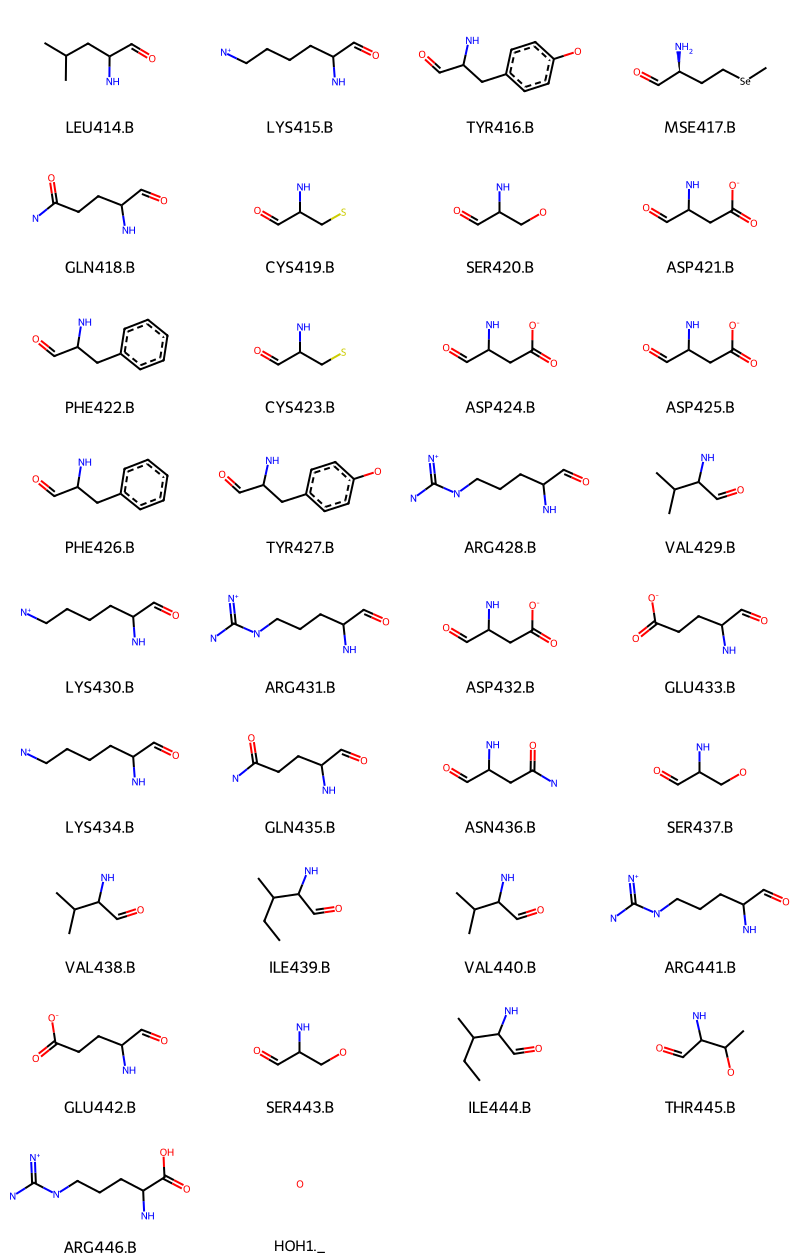

In [94]:
plf.display_residues(protein_mol, slice(800, 835), sanitize=False)

In [ ]:
ligands = []
for ligand_sdf in os.listdir(test_case_dir):  # noqa: PTH208
    if ligand_sdf.endswith("_protonated.sdf"):
        ligands.extend(plf.sdf_supplier(f"{test_case_dir}/{ligand_sdf}"))

In [52]:
# plf.display_residues(ligands[0])

In [96]:
ligands

[<prolif.molecule.Molecule with 1 residues and 47 atoms at 0x7f2bc4270630>,
 <prolif.molecule.Molecule with 1 residues and 1 atoms at 0x7f2cd88d1df0>]

In [97]:
dfs = []
fps = []
for each_ligand in ligands:
    fp = plf.Fingerprint(["HBDonor", "HBAcceptor"], count=True)
    fp.run_from_iterable([each_ligand], protein_mol)
    df = fp.to_dataframe().T
    dfs.append(df)
    fps.append(fp)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/yuyang/Project_local/GSoC2025_Hbond_PM/.venv/lib/python3.11/site-packages/prolif/fingerprint.py:961: UserWarning: No interaction detected
  return to_dataframe(


In [98]:
dfs[0]

Frame                        0
ligand protein  interaction   
UNL1   ARG13.A  HBAcceptor   1
       ASN36.A  HBAcceptor   1
       GLY37.A  HBAcceptor   1
       GLY39.A  HBAcceptor   1
       LYS40.A  HBAcceptor   1
       THR41.A  HBAcceptor   1
       THR42.A  HBAcceptor   1
       ALA64.A  HBDonor      1
       ASP68.A  HBAcceptor   1
       GLN159.A HBAcceptor   1
       ARG431.A HBAcceptor   1
       GLY344.B HBAcceptor   1
       GLN345.B HBAcceptor   1

In [99]:
view = fps[0].plot_lignetwork(ligands[0], kind="frame", frame=0, display_all=False)
view

In [101]:
# Somtimes not working, need to check
# view = fps[0].plot_3d(ligands[0], protein_mol, frame=0, display_all=True)
# view

## Implicit

In [102]:
from prolif.molecule import Molecule

protein_mol_i = protein_helper.standardize_protein(
    Molecule.from_rdkit(
        Chem.MolFromPDBFile(f"{test_case_dir}/receptor_protonated2.pdb")
    )
)

In [59]:
# plf.display_residues(protein_mol_i, slice(230, 270), sanitize=False)

In [103]:
ligands_i = []
for ligand in ligands:
    ligands_i.append(Molecule.from_rdkit(Chem.RemoveAllHs(ligand)))

In [104]:
ligands_i

[<prolif.molecule.Molecule with 1 residues and 31 atoms at 0x7f2cd8798450>,
 <prolif.molecule.Molecule with 1 residues and 1 atoms at 0x7f2bdc00fab0>]

In [ ]:
dfs_i = []
fps_i = []
for each_ligand in ligands_i:
    fp = plf.Fingerprint(
        ["ImplicitHBDonor", "ImplicitHBAcceptor"],
        count=True,
        parameters={
            "ImplicitHBDonor": {
                "include_water": True,  # include water molecules
                "tolerance_dev_aaa": 50,  # angle deviation tolerance for acceptor atom
                "tolerance_dev_daa": 50,  # angle deviation tolerance for donor atom
                "tolerance_dev_dpa": 50,  # angle deviation tolerance for donor plane
                "tolerance_dev_apa": 90,  # angle deviation tolerance for acceptor plane
            },
            "ImplicitHBAcceptor": {
                "include_water": True,  # include water molecules
                "tolerance_dev_aaa": 50,  # angle deviation tolerance for acceptor atom
                "tolerance_dev_daa": 50,  # angle deviation tolerance for donor atom
                "tolerance_dev_dpa": 50,  # angle deviation tolerance for donor plane
                "tolerance_dev_apa": 90,  # angle deviation tolerance for acceptor plane
            },
        },
    )
    fp.run_from_iterable([each_ligand], protein_mol_i)
    df = fp.to_dataframe().T
    dfs_i.append(df)
    fps_i.append(fp)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/yuyang/Project_local/GSoC2025_Hbond_PM/.venv/lib/python3.11/site-packages/prolif/fingerprint.py:961: UserWarning: No interaction detected
  return to_dataframe(


In [119]:
view = fps_i[0].plot_lignetwork(ligands_i[0], kind="frame", frame=0, display_all=False)
view

In [120]:
view = fps_i[0].plot_3d(ligands_i[0], protein_mol_i, frame=0, display_all=True)
view.setStyle(
    {
        "resn": "HOH",
    },
    {"sphere": {"radius": 0.5, "color": "red"}},
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [121]:
from metrics import (
    confusion_matrix,
    get_interactions,
    plot_confusion_matrix,
    tanimoto_coefficient_by_confusion_matrix,
)

In [122]:
matrices = []
tm_coefs = []
for df, df_i in zip(dfs, dfs_i, strict=False):
    explicit_set = get_interactions(df)
    implicit_set = get_interactions(df_i)

    matrix = confusion_matrix(explicit_set, implicit_set)
    tm_coef = tanimoto_coefficient_by_confusion_matrix(matrix)
    matrices.append(matrix)
    tm_coefs.append(tm_coef)

Tanimoto coefficient: 0.5652173913043478


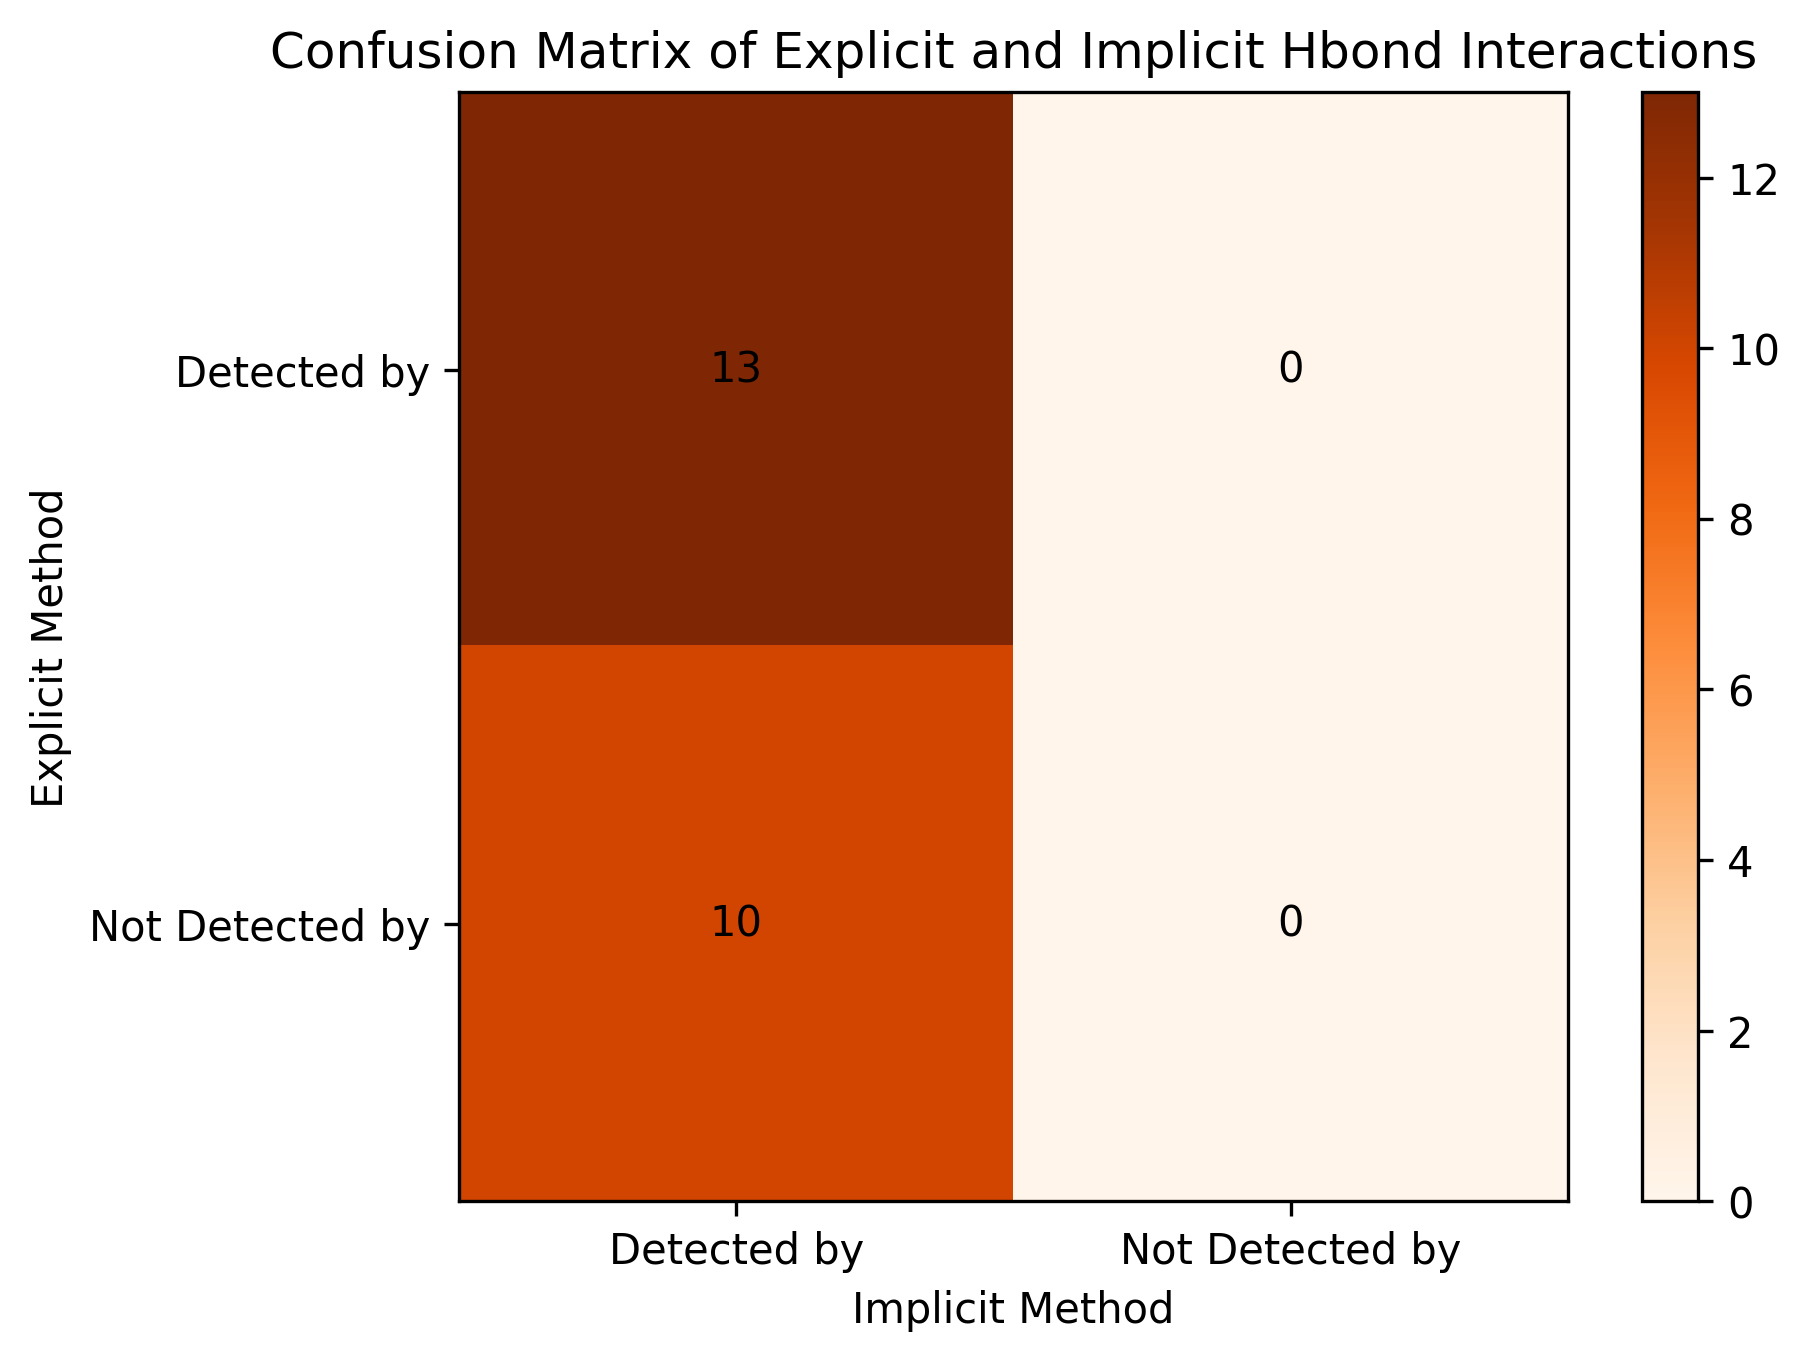

In [ ]:
ligand_idx = 0

print("Tanimoto coefficient:", tm_coefs[ligand_idx])  # noqa: T201
fig, ax = plot_confusion_matrix(matrices[ligand_idx])
fig.show()

# Dev: find the atom angles for possible pairs

In [124]:
explicit_set = get_interactions(dfs[ligand_idx])

In [125]:
explicit_set

{('UNL1', 'ALA64.A', 'HBD'),
 ('UNL1', 'ARG13.A', 'HBA'),
 ('UNL1', 'ARG431.A', 'HBA'),
 ('UNL1', 'ASN36.A', 'HBA'),
 ('UNL1', 'ASP68.A', 'HBA'),
 ('UNL1', 'GLN159.A', 'HBA'),
 ('UNL1', 'GLN345.B', 'HBA'),
 ('UNL1', 'GLY344.B', 'HBA'),
 ('UNL1', 'GLY37.A', 'HBA'),
 ('UNL1', 'GLY39.A', 'HBA'),
 ('UNL1', 'LYS40.A', 'HBA'),
 ('UNL1', 'THR41.A', 'HBA'),
 ('UNL1', 'THR42.A', 'HBA')}

In [126]:
aaa_dev_list = []
daa_dev_list = []
dpa_list = []
apa_list = []
for each_pair in explicit_set:
    metadata = fps_i[ligand_idx].ifp[0][each_pair[0:2]]
    for each_interaction_type in metadata:
        for each_metadata in metadata[each_interaction_type]:
            if "acceptor_atom_angle_deviation" in each_metadata:
                aaa_dev_list.append(each_metadata["acceptor_atom_angle_deviation"])
            if "donor_atom_angle_deviation" in each_metadata:
                daa_dev_list.append(each_metadata["donor_atom_angle_deviation"])
            if "donor_plane_angle" in each_metadata:
                dpa_list.append(each_metadata["donor_plane_angle"])
            if "acceptor_plane_angle" in each_metadata:
                apa_list.append(each_metadata["acceptor_plane_angle"])

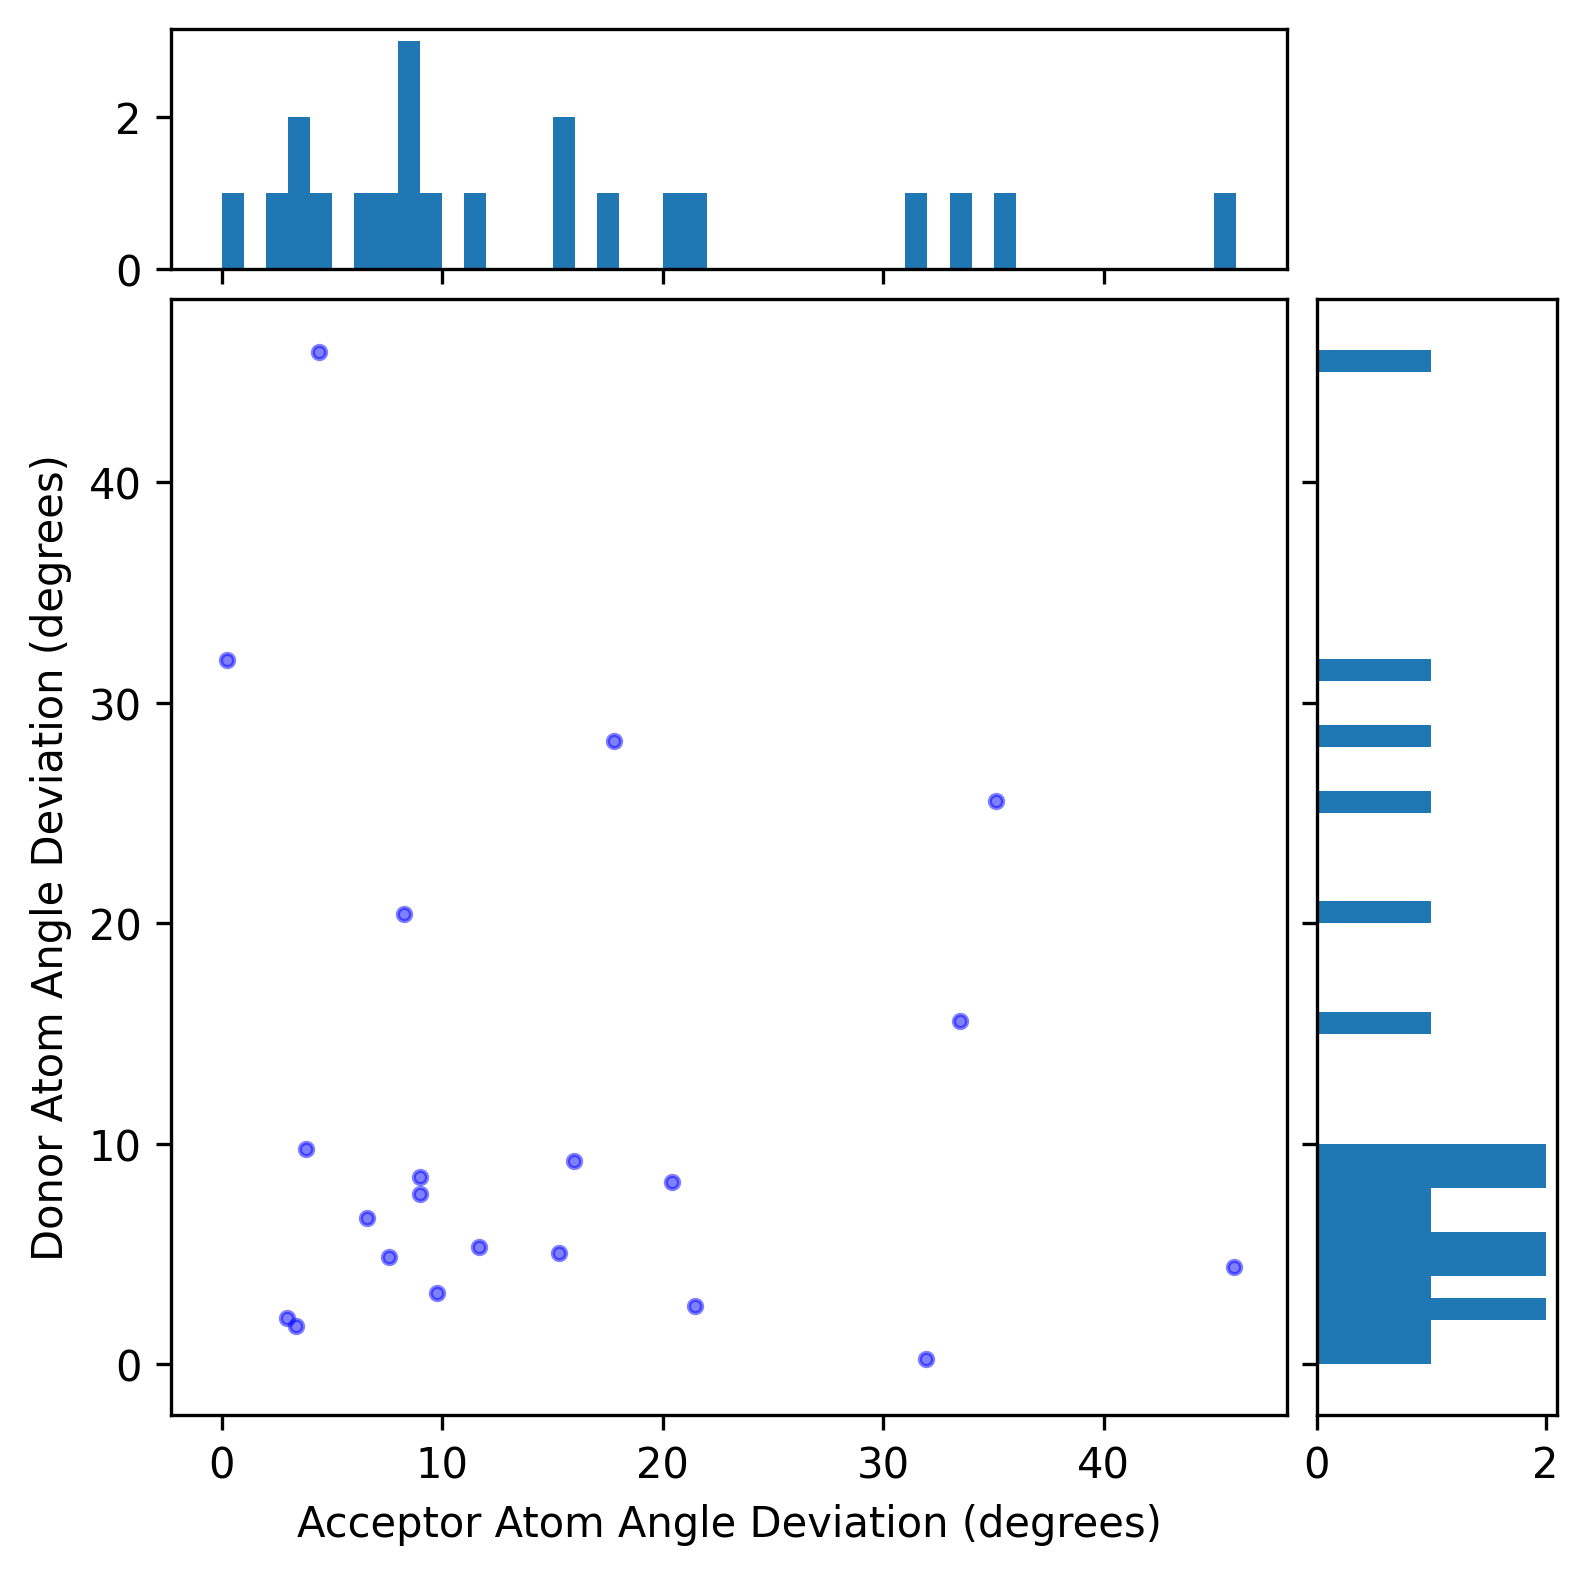

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(dpi=300, figsize=(8, 6))
ax.scatter(aaa_dev_list, daa_dev_list, s=10, alpha=0.5, c="blue")


# the scatter plot:
# Set aspect of the main Axes.
ax.set_aspect(1.0)

# create new Axes on the right and on the top of the current Axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 0.8, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 0.8, pad=0.1, sharey=ax)

# make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 1
xymax = max(np.max(np.abs(aaa_dev_list)), np.max(np.abs(daa_dev_list)))
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax_histx.hist(aaa_dev_list, bins=bins)
ax_histy.hist(daa_dev_list, bins=bins, orientation="horizontal")

# the xaxis of ax_histx and yaxis of ax_histy are shared with ax,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

# ax_histx.set_yticks([0, 50, 100])
# ax_histy.set_xticks([0, 50, 100])

ax.set_xlabel("Acceptor Atom Angle Deviation (degrees)")
ax.set_ylabel("Donor Atom Angle Deviation (degrees)")
fig.show()